In [3]:
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from pyserini.search import LuceneSearcher
np.set_printoptions(suppress=True,precision=4)
msmarco_data = 'data/trec/fulldocs-new.trec'




In [2]:

def extract_docs(file):
    with open(file, 'r') as f:
        docno = url = content = None
        for line in f:
            if line.startswith('<DOCNO>'):
                docno = line.replace('<DOCNO>', '').replace('</DOCNO>', '').strip()
            elif line.startswith('<TEXT>'):
                content = []
            elif line.startswith('</TEXT>'):
                content = '\n'.join(content)
                url_match = re.search(r'https?://\S+', content)
                if url_match:
                    url = url_match.group()
                    content = content[len(url):].strip()
                else:
                    url = None
                yield {'docno': docno, 'url': url, 'content': content}
                content = None
            elif content is not None:
                content.append(line.strip())

num_docs = 0
doc_lengths = []

with open('output/doc_lengths.csv', 'w', newline='') as csvfile:
    fieldnames = ['doc_id', 'length']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for doc in extract_docs(msmarco_data):
        num_docs += 1
        length = len(doc['content'])
        doc_lengths.append(length)
        writer.writerow({'doc_id': doc['docno'], 'length': length})

doc_lengths_array = np.array(doc_lengths)
del doc_lengths

  Statistic     Documents      Queries
0     Total  3.213835e+06  4999.000000
1       Min  0.000000e+00     2.000000
2       Max  2.064096e+06    33.000000
3    Median  3.577000e+03     6.000000
4   Average  6.996613e+03     5.927786


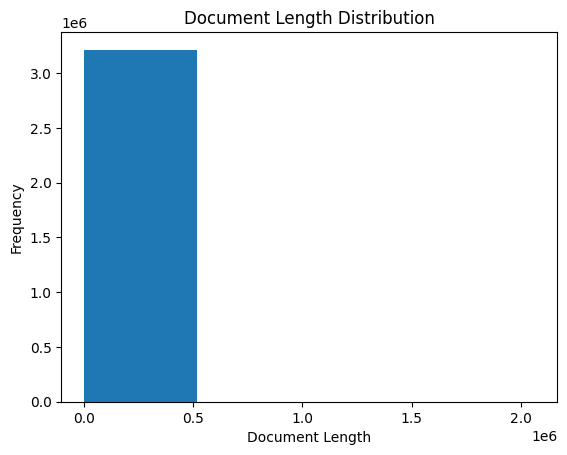

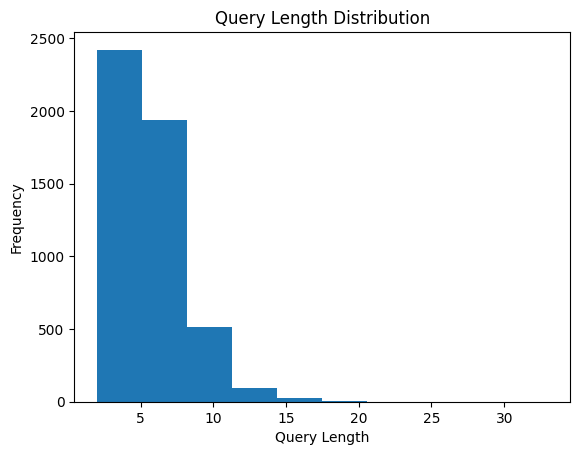

In [6]:

index_path = "pyserini/indexes/full_index"

searcher = LuceneSearcher(index_path)

total_docs = searcher.num_docs
doc_lengths = []

# Assuming you have a file with the queries
path_to_queries = "data/proc_data/train_sample/sample_queries.tsv"

# Read the queries file into a DataFrame
queries_df = pd.read_csv(path_to_queries, sep=" ", header=None, names=["query"])
queries_df["query_length"] = queries_df["query"].apply(lambda x: len(x.split()))

total_queries = len(queries_df)

query_lengths = queries_df["query_length"].values



# Create a summary table
summary_table = pd.DataFrame({
    "Statistic": ["Total", "Min", "Max", "Median", "Average"],
    "Documents": [total_docs, np.min(doc_lengths_array), np.max(doc_lengths_array), np.median(doc_lengths_array), np.mean(doc_lengths_array)],
    "Queries": [total_queries, np.min(query_lengths), np.max(query_lengths), np.median(query_lengths), np.mean(query_lengths)]
})
summary_table.to_csv("output/summary_table.csv", index=False)
print(summary_table)

# Plot document length distribution

# doc_lengths_array = pd.DataFrame(doc_lengths_array, columns=["doc_length"], index=range(1, total_docs+1))
doc_df = pd.DataFrame(doc_lengths_array.T, columns=["doc_length"])
docs = doc_df['doc_length'].values
plt.figure()
plt.hist(doc_df, bins=4 )
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.title("Document Length Distribution")
plt.show()
# Plot query length distribution
plt.figure()
plt.hist(query_lengths, bins=10)
plt.xlabel("Query Length")
plt.ylabel("Frequency")
plt.title("Query Length Distribution")
plt.show()
docs
query_lengths
summary_table
doc_df.to_csv("output/doc_lengths.csv", index=False)


In [18]:
import collections
import os
import time
from typing import IO, Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import pyterrier as pt
import pytrec_eval
from pyserini.index import IndexReader
from pyserini.search import LuceneSearcher, SimpleSearcher

from pyserini.index import IndexReader
from typing import Set

def count_unique_terms(index_path: str) -> int:
    """
    Count the number of unique terms in a given index.

    Args:
        index_path (str): The path to the index.

    Returns:
        int: The number of unique terms in the index.
    """
    reader = IndexReader(index_path)
    num_unique_terms = 0

    # Iterate over all terms in the index
    for _ in tqdm(reader.terms(), desc="Counting unique terms", unit="term"):
        num_unique_terms += 1

    return num_unique_terms



def measure_query_time(searcher: LuceneSearcher, query: str) -> float:
    """
    Measure the time taken to execute a query on a given searcher.

    Args:
        searcher (LuceneSearcher): The searcher to use for the query.
        query (str): The query string to execute.

    Returns:
        float: The time taken to execute the query in seconds.
    """
    start_time = time.time()
    searcher.search(query)
    end_time = time.time()
    return end_time - start_time

def measure_average_query_time(searcher: LuceneSearcher, queries: List[str]) -> float:
    """
    Measures the average time taken to perform a search.

    Args:
        searcher (LuceneSearcher): The searcher instance to perform the search.
        queries (List[str]): The list of search queries.

    Returns:
        float : The average time taken to perform the search.
    """
    total_time = 0
    for query in queries:
        total_time += measure_query_time(searcher, query)
    return total_time / len(queries)

def get_size(path: str) -> int:
    """
    Recursively computes the total size of a file or directory.

    Args:
        path (str): Path to the file or directory.

    Returns:
        int: Total size in bytes.
    """
    total = 0
    for entry in os.scandir(path):
        if entry.is_file():
            total += entry.stat().st_size
        elif entry.is_dir():
            total += get_size(entry.path)
    return total
    
def measure_index_statistics(
    queries: List[str], index_variants: List[Dict]
) -> pd.DataFrame:
    results = []
    for variant in index_variants:
        index_path = variant["index_path"]
        print(index_path)
        # Initialize a searcher and index reader
        searcher = LuceneSearcher(index_path)
        reader = IndexReader(index_path)

        # Collect index statistics
        num_docs = reader.stats()["documents"]
        num_terms = reader.stats()["unique_terms"]
        total_terms = reader.stats()["total_terms"]

        # Measure index size and search time
        index_size = get_size(index_path)
        avg_search_time = measure_average_query_time(searcher, queries)

        results.append(
            {
                "name": variant["name"],
                "num_docs": num_docs,
                "total_terms": total_terms,
                "index_size": index_size,
                "avg_search_time": avg_search_time,
            }
        )

    # Create pandas DataFrame and save as CSV file
    df = pd.DataFrame(results)
    print(num_terms)
    df.to_csv("index_statistics.csv", index=False)

    return df


In [19]:
output_folder = "pyserini/indexes/"

index_variants = [
    {
        "name": "full_index",
        "index_path": output_folder + "full_index/",
        "stopwords": False,
        "stemming": False,
    },
    {
        "name": "stopwords_removed",
        "index_path": output_folder + "stopwords_removed/",
        "stopwords": True,
        "stemming": False,
    },
    {
        "name": "stemming/",
        "index_path": output_folder + "stemming/",
        "stopwords": False,
        "stemming": True,
    },
    {
        "name": "stopwords_removed_stemming",
        "index_path": output_folder + "stopwords_removed_stemming/",
        "stopwords": True,
        "stemming": True,
    },
]
print(index_variants)

measure_index_statistics("data/proc_data/train_sample/sample_queries.tsv",index_variants)

[{'name': 'full_index', 'index_path': 'pyserini/indexes/full_index/', 'stopwords': False, 'stemming': False}, {'name': 'stopwords_removed', 'index_path': 'pyserini/indexes/stopwords_removed/', 'stopwords': True, 'stemming': False}, {'name': 'stemming/', 'index_path': 'pyserini/indexes/stemming/', 'stopwords': False, 'stemming': True}, {'name': 'stopwords_removed_stemming', 'index_path': 'pyserini/indexes/stopwords_removed_stemming/', 'stopwords': True, 'stemming': True}]
pyserini/indexes/full_index/
pyserini/indexes/stopwords_removed/
pyserini/indexes/stemming/
pyserini/indexes/stopwords_removed_stemming/
-1


,name,num_docs,total_terms,index_size,avg_search_time
0,full_index,3213835,3726794922,16911348024,0.001229
1,stopwords_removed,3213835,2719825877,16806550019,0.001047
2,stemming/,3213835,3726794922,16652941347,0.001177
3,stopwords_removed_stemming,3213835,2719825877,16552139947,0.001033


In [20]:
from pyserini.index.lucene import IndexReader
index = IndexReader("pyserini/indexes/full_index/")
vocabulary_len = index.stats()['unique_terms']
index.stats()

{'total_terms': 3726794922,
 'documents': 3213835,
 'non_empty_documents': 3213835,
 'unique_terms': -1}